# TT1 - MDM UBA - 2025

## Clasificación arancelaria mediante NLP

BERT for HS04

Using transformers (BERT models)

In [1]:
# Dependencies

import os

import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import re

import matplotlib.pyplot as plt


## Good descriptions

Using a descriptions sample.

In [2]:

colspecs = [(0, 6), (6, None)]
data_type = {'HS': str}

# Read the text file using the read_fwf function
df = pd.read_fwf('data/raw_data_HScodes_desc.txt', 
                 colspecs=colspecs, header=None, 
                 names=['HS', 'GOODS_DECRIPTION'], 
                 dtype=data_type)

df_example = df#.sample(10000, random_state=42)

print('Data information')
print(df_example.info())

raw_len = len(df_example)
print('Lenght of raw data:', raw_len)

# HS Chapter 

df_example['HS02'] = df_example['HS'].astype(str).str[0:2]
df_example['HS'] = df_example['HS'].astype(str).str[0:4]

# dropping duplicates

df_example = df_example.drop_duplicates(subset=['HS', 'GOODS_DECRIPTION']).sort_values(by=['HS', 'GOODS_DECRIPTION']).reset_index(drop=True)

print('Lenght after from duplicates:', len(df_example))

# dropping missing values

df_example.dropna(subset=['HS', 'GOODS_DECRIPTION'], inplace=True)

print('Lenght after drop nulls:', len(df_example))

Data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   HS                500000 non-null  object
 1   GOODS_DECRIPTION  500000 non-null  object
dtypes: object(2)
memory usage: 7.6+ MB
None
Lenght of raw data: 500000
Lenght after from duplicates: 267780
Lenght after drop nulls: 267780


In [100]:
len(df_example['HS'].unique())

1133

In [3]:
df_example

,HS,GOODS_DECRIPTION,HS02
0,0101,GRANULATOR SCREW,01
1,0101,LIVE BREEDING FARM HORSE,01
2,0101,LIVE BREEDING FARM HORSE LULUS PICASSOS VISUAL,01
3,0101,LIVE BREEDING FARM HORSE SILOHA NASMAT,01
4,0101,LIVE FARM HORSE,01
...,...,...,...
267775,9704,TAX STAMPS,97
267776,9705,GIFT ITEMS (CONT NO. TTNU477852 40FT),97
267777,9705,HARDWARE,97
267778,9705,HUMAN SKELETON,97


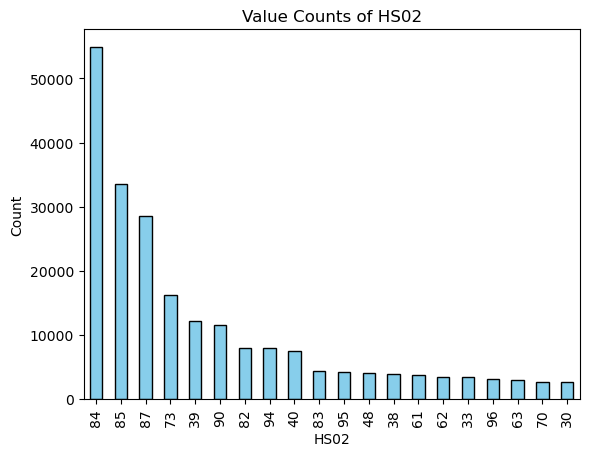

In [4]:
# Plotting top20 HS02

df_example['HS02'].value_counts()[0:20].plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('HS02')
plt.ylabel('Count')
plt.title('Value Counts of HS02')

plt.show()

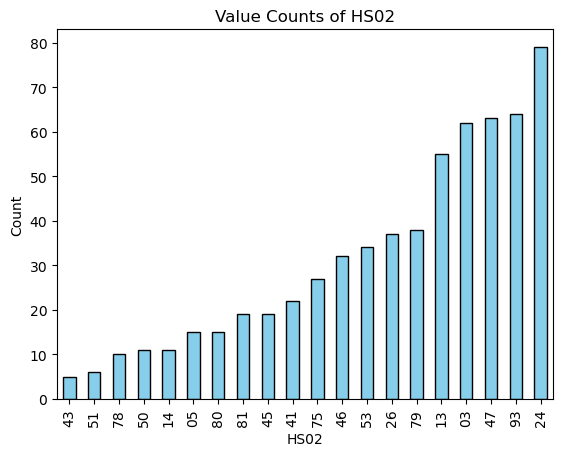

In [5]:
# Plotting botton20 HS02

df_example['HS02'].value_counts(ascending=True)[0:20].plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('HS02')
plt.ylabel('Count')
plt.title('Value Counts of HS02')

plt.show()

## Preprocessing

Cleaning and treating the descriptions aiming to improve the model performance.

In [6]:
def preprocess_goods_description(df, column_name):

    df_copy = df.copy()
    
    def preprocess_text(text):
        # Step 1: Separate numbers and symbols from text with a blank space
        text = re.sub(r'([0-9])([^0-9\s.])', r'\1 \2', text)
        text = re.sub(r'([^0-9\s.])([0-9])', r'\1 \2', text)
        text = re.sub(r'([^\w\s])', r' \1 ', text)
        
        # Step 2: Check if decimal numbers were separated and erase blanks to form decimal numbers again
        text = re.sub(r'(\d+)\s+\.\s+(\d+)', r'\1.\2', text)
        
        # Step 3: Delete specific symbols, except dots representing decimal separation
        text = re.sub(r'[()\\[\]\'":;,_]', '', text)
        
        # Step 4: Erase double blanks
        text = re.sub(r'\s+', ' ', text)
        
        return text
    
    # Saving original descriptions
    df_copy['desc_orinal'] = df_copy[column_name]

    # Apply preprocessing to the specified column
    df_copy[column_name] = df_copy[column_name].apply(preprocess_text)
    
    return df_copy

In [7]:
df_example = preprocess_goods_description(df_example, 'GOODS_DECRIPTION')

In [8]:
df_example.head(5)

,HS,GOODS_DECRIPTION,HS02,desc_orinal
0,0101,GRANULATOR SCREW,01,GRANULATOR SCREW
1,0101,LIVE BREEDING FARM HORSE,01,LIVE BREEDING FARM HORSE
2,0101,LIVE BREEDING FARM HORSE LULUS PICASSOS VISUAL,01,LIVE BREEDING FARM HORSE LULUS PICASSOS VISUAL
3,0101,LIVE BREEDING FARM HORSE SILOHA NASMAT,01,LIVE BREEDING FARM HORSE SILOHA NASMAT
4,0101,LIVE FARM HORSE,01,LIVE FARM HORSE


## BERT model application

Using distilbert

In [9]:
def bootstrap_sampling(df, test_fraction=0.1):
    # Determine the number of test samples
    n_test = int(len(df) * test_fraction)
    # Perform bootstrap sampling for the test set
    test_set = df.sample(n=n_test, replace=True)
    # Remove the test samples from the original dataframe to create the training set
    train_set = df.drop(test_set.index)
    
    return train_set, test_set

### Dataset preparation

In [10]:
import os
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel
# from transformers import Trainer, TrainingArguments, TrainerCallback
import torch
# import json

# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Custom Dataset Class
class HS_Desc_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length, label2id, 
                 hs_code_col = 'HS', good_desc_col = 'GOODS_DECRIPTION'):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label2id = label2id
        self.hs_code_col = hs_code_col
        self.good_desc_col = good_desc_col

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx][self.good_desc_col]
        label = self.label2id[str(self.data.iloc[idx][self.hs_code_col])]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create label mappings
unique_labels = df_example['HS'].unique()
label2id = {str(label): idx for idx, label in enumerate(unique_labels)}
id2label = {idx: str(label) for idx, label in enumerate(unique_labels)}

# Split the data into train and validation sets
train_df, val_df = bootstrap_sampling(df_example, test_fraction=0.1)

# Create dataset instances
max_length = 128
train_dataset = HS_Desc_Dataset(dataframe=train_df, tokenizer=tokenizer, max_length=max_length, label2id=label2id)
val_dataset = HS_Desc_Dataset(dataframe=val_df, tokenizer=tokenizer, max_length=max_length, label2id=label2id)

# Batch size
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

c:\Users\santt\.conda\envs\bacuda_synt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Transfer learning

Model definition

Complexity adaptable to n_classes

In [11]:
# Define the custom model
class HSClassifier(nn.Module):
    def __init__(self, n_classes, fine_tune=False):
        super(HSClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        
        # Freeze the DistilBERT layers
        for param in self.distilbert.parameters():
            param.requires_grad = fine_tune # Whether to fine-tune the transformer model
        
        self.classifier = nn.Sequential(
            nn.Linear(self.distilbert.config.hidden_size, int(n_classes/3)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(int(n_classes/3), int(n_classes/2)),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(int(n_classes/2), int(n_classes*1.5)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(int(n_classes*1.5), n_classes)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Take <CLS> token representation
        logits = self.classifier(hidden_state)
        return logits

Training

In [12]:
# Accuracy functions
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item()

def top3_accuracy(outputs, labels):
    top3 = torch.topk(outputs, 3, dim=1).indices
    return sum([labels[i] in top3[i] for i in range(labels.size(0))])

# Training loop
def train_epoch(model, data_loader, criterion, optimizer, device):
    model = model.train()
    losses = []
    correct_predictions = 0
    correct_top3_predictions = 0
    
    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, labels)

        correct_predictions += accuracy(outputs, labels)
        correct_top3_predictions += top3_accuracy(outputs, labels)
        
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return correct_predictions / len(data_loader.dataset), correct_top3_predictions / len(data_loader.dataset), np.mean(losses)

def eval_model(model, data_loader, criterion, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    correct_top3_predictions = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)

            correct_predictions += accuracy(outputs, labels)
            correct_top3_predictions += top3_accuracy(outputs, labels)
            
            losses.append(loss.item())
    
    return correct_predictions / len(data_loader.dataset), correct_top3_predictions / len(data_loader.dataset), np.mean(losses)

Transfer learning, without fine-tuning

In [13]:
# import time

# # Initialize the model, loss function, and optimizer
# model = HSClassifier(n_classes=len(label2id), fine_tune=False)
# model_name = 'distiltbert_hs04_classifier_transferlearning'

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Training on {device}')
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# # Initialize history dictionary
# history = {
#     'train_loss': [],
#     'train_acc': [],
#     'train_top3_acc': [],
#     'val_loss': [],
#     'val_acc': [],
#     'val_top3_acc': []
# }

# # Training the model
# num_epochs = 20
# for epoch in range(num_epochs):
#     print(f'Epoch {epoch + 1}/{num_epochs}')
#     print('-' * 10)

#     start_time = time.time()
    
#     train_acc, train_top3_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
#     print(f'Train loss {train_loss} accuracy {train_acc} top3_accuracy {train_top3_acc}')
    
#     val_acc, val_top3_acc, val_loss = eval_model(model, val_loader, criterion, device)
#     print(f'Validation loss {val_loss} accuracy {val_acc} top3_accuracy {val_top3_acc}')

#     end_time = time.time()
#     epoch_time = end_time - start_time
#     print(f"Epoch {epoch + 1} completed in {epoch_time/60:.2f} minutes.\n")    
    
#     # Update history
#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['train_top3_acc'].append(train_top3_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
#     history['val_top3_acc'].append(val_top3_acc)

# print("Training complete.")

Takes aprox. 0.5 min/epoch. with 10000 samples (~ 9800 uniques)

Takes aprox. 5 min/epoch. with 50000 samples (~ 45000 uniques)

Takes aprox. 5 min/epoch. with 100000 samples (~ 90000 uniques)

Takes aprox. 15 min/epoch with 500000 samples (how many uniques?)

> Without text preprocessing:
Epoch 3/3 and 10000 samples (~ 9800 uniques)

Train loss 6.4709294047406924 accuracy 0.04673839946200403 top3_accuracy 0.08282896211611747

Validation loss 6.56917755834518 accuracy 0.05989847715736041 top3_accuracy 0.11573604060913706

Epoch 3 completed in 0.44 minutes.

> With text preprocessing:
Epoch 3/3 and 10000 samples (~ 9800 uniques)

Train loss 6.460037977464737 accuracy 0.04619351945285346 top3_accuracy 0.08476286579212916

Validation loss 6.681445967766546 accuracy 0.06294416243654823 top3_accuracy 0.1116751269035533

Epoch 3 completed in 0.59 minutes.



In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to plot metrics
def plot_metric(history, metric, validation=True):
    plt.plot(history['train_' + metric], label=f'Training {metric}')
    if validation:
        plt.plot(history['val_' + metric], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric}')
    else:
        plt.title(f'Training {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    if validation:
        plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# history_without_fine_tuning = history

In [16]:
# plot_metric(history_without_fine_tuning, 'loss' )
# plot_metric(history_without_fine_tuning, 'acc' )
# plot_metric(history_without_fine_tuning, 'top3_acc' )

In [17]:
# from datetime import datetime

# time_now = datetime.now().strftime('%d%m%Y_%H%M%S')

# # Save the trained model
# model_save_path = f'{model_name}_{num_epochs}epochs_{time_now}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

### Fine-tuning

Takes aprox. 1.2 min/epoch. with 10000 samples (~ 9800 uniques)

Takes aprox. 6 min/epoch. with 50000 samples (~ 45000 uniques)

Takes aprox. 12 min/epoch. with 100000 samples (~ 90000 uniques)

> Without text preprocessing:
Epoch 3/3 and 10000 samples (~ 9800 uniques)

Train loss 5.564470847447713 accuracy 0.10759919300605246 top3_accuracy 0.16991705895539116

Validation loss 6.0270687303235455 accuracy 0.1431472081218274 top3_accuracy 0.2152284263959391

Epoch 3 completed in 1.25 minutes. 

> With text preprocessing:

Epoch 3/3 and 10000 samples (~ 9800 uniques)

Train loss 5.3870295444269765 accuracy 0.12546249579549276 top3_accuracy 0.20529207310236575

Validation loss 6.0406197809403945 accuracy 0.13705583756345177 top3_accuracy 0.21116751269035533

Epoch 3 completed in 1.39 minutes. 

Overfitting in fine-tuning, options:

- More data (samples)
- More dropout and regularization
- Less complexity in the head (check classifier head by default)
- Text preprocessing?

#### Updating vocabulary 

with 20 % more tokens, taking more frequent new tokens

This seems unnecessary because of the robustness of the tokenizer, which subtokenization is breaking the words into known tokens.

In [18]:
from collections import Counter
import re

# Get the current vocabulary
current_vocab = set(tokenizer.vocab.keys())

rate_to_increase_vocab = 0.2 # 20 %

# Calculate the dynamic threshold
threshold = int(len(current_vocab) * rate_to_increase_vocab)

# Extract unique words from the text column and measure frequency
token_counter = Counter()
for text in df_example['GOODS_DECRIPTION']:
    tokens = text.lower().split()  # Transform to uppercase and basic tokenization
    tokens = [token for token in tokens if not re.match(r'\d+', token) and len(token) > 2]  # Drop numeric elements and two-character tokens
    token_counter.update(tokens)

# Identify new tokens
unique_words = set(token_counter.keys())
new_tokens = unique_words - current_vocab

# Measure frequency of new tokens
new_token_freq = {token: token_counter[token] for token in new_tokens}

# Get the most recurrent new tokens representing 10% of the length of the current vocabulary
sorted_new_tokens = sorted(new_token_freq.items(), key=lambda x: x[1], reverse=True)
top_recurrent_new_tokens = [token for token, freq in sorted_new_tokens[:threshold]]

len(top_recurrent_new_tokens)

6104

In [19]:
top_recurrent_new_tokens

['chs',
 'assy',
 'yom',
 'ckd',
 'huoniao',
 'pvc',
 'ljepcjl',
 'chass',
 'gasket',
 'washer',
 'scania',
 'assorted',
 'clamp',
 'spares',
 'mtr',
 'nsk',
 'ltr',
 'polyester',
 'flange',
 'subaru',
 'alphard',
 'std',
 'excavator',
 'anh',
 'rhd',
 'hex',
 'adapter',
 'wrench',
 'nozzle',
 'ncp',
 'heater',
 'charger',
 'canter',
 'dayliff',
 'adhesive',
 'mcb',
 'kva',
 'galvanized',
 'thrasher',
 'faw',
 'mould',
 'forester',
 'radiator',
 'disposable',
 'unassembled',
 'harrier',
 'fittings',
 'lyo',
 'polypropylene',
 'acu',
 'mmx',
 'comp',
 'transformer',
 'bushing',
 'grinder',
 'pulley',
 'kgs',
 'gsm',
 'loader',
 'solenoid',
 'hdpe',
 'cooker',
 'isuzu',
 'pneumatic',
 'bngg',
 'corolla',
 'cyl',
 'adaptor',
 'conveyor',
 'forklift',
 'komatsu',
 'polyethylene',
 'cartons',
 'mens',
 'gms',
 'hexagon',
 'spanner',
 'dryer',
 'absorber',
 'lalja',
 'vdc',
 'hilux',
 'hyd',
 'wiper',
 'howo',
 'vac',
 'crusher',
 'suction',
 'pce',
 'fuso',
 'grs',
 'toner',
 'nze',
 'ctn',

In [20]:
# import time

# # Updating tokenizer
# tokenizer.add_tokens(top_recurrent_new_tokens)

# # Initialize the model, loss function, and optimizer
# model = HSClassifier(n_classes=len(label2id), fine_tune=True)
# model_name = 'distiltbert_hs04_classifier_finetuned_extra+20tokens'

# # Resize the Model's Token Embeddings
# model.distilbert.resize_token_embeddings(len(tokenizer))

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f'Training on {device}')
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# # Initialize history dictionary
# history = {
#     'train_loss': [],
#     'train_acc': [],
#     'train_top3_acc': [],
#     'val_loss': [],
#     'val_acc': [],
#     'val_top3_acc': []
# }

# # Training the model
# num_epochs = 10
# for epoch in range(num_epochs):
#     print(f'Epoch {epoch + 1}/{num_epochs}')
#     print('-' * 10)
    
#     start_time = time.time()

#     train_acc, train_top3_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
#     print(f'Train loss {train_loss} accuracy {train_acc} top3_accuracy {train_top3_acc}')
    
#     val_acc, val_top3_acc, val_loss = eval_model(model, val_loader, criterion, device)
#     print(f'Validation loss {val_loss} accuracy {val_acc} top3_accuracy {val_top3_acc}')

#     end_time = time.time()
#     epoch_time = end_time - start_time
#     print(f"Epoch {epoch + 1} completed in {epoch_time/60:.2f} minutes. \n")    
    
#     # Update history
#     history['train_loss'].append(train_loss)
#     history['train_acc'].append(train_acc)
#     history['train_top3_acc'].append(train_top3_acc)
#     history['val_loss'].append(val_loss)
#     history['val_acc'].append(val_acc)
#     history['val_top3_acc'].append(val_top3_acc)

# print("Training complete.")


Issues with this training

Takes 30 min/epochs with 500000 descriptions

Finding overfitting beyond 5 epochs

Trying again with more dropout. If does not work, we could try the default classi head for distiltbert, with the trainer and regularization.

In [21]:
# plot_metric(history, 'loss' )
# plot_metric(history, 'acc' )
# plot_metric(history, 'top3_acc' )

Using the entire dataset, 500 thousands samples, with 4~5 epochs is enough and overfitting is found beyond that iteration. 

In [22]:
# model_name

In [23]:
# from datetime import datetime

# time_now = datetime.now().strftime('%d%m%Y_%H%M%S')

# # model_name = 'distiltbert_hs_classifier_finetuned_dict_updated'

# # Save the trained model
# model_save_path = f'{model_name}_{num_epochs}epochs_{time_now}.pth'
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")

### Using trained models

Sample to test

In [24]:
df_test_sample = val_df.sample(1000, random_state=42)

Predict and evaluate function

In [25]:
def predict_and_evaluate(model, tokenizer, unseen_sample, id2label, max_length=128, device='cpu'):
    """
    Predicts the top 3 classes and their probabilities for an unseen sample using a given model and tokenizer.
    Calculates the accuracy for top 1, top 2, and top 3 predictions.

    Parameters:
    model (nn.Module): Trained PyTorch model for prediction.
    tokenizer (Tokenizer): Tokenizer to preprocess the data.
    unseen_sample (DataFrame): Unseen data sample with 'GOODS_DECRIPTION' and 'true_label' columns.
    id2label (dict): Dictionary mapping label IDs to label names.
    max_length (int): Maximum length for tokenization.
    device (str): Device to run the model on ('cpu' or 'cuda').

    Returns:
    DataFrame: DataFrame containing true labels, top 3 predicted labels, and their probabilities.
    """
    
    # Tokenize the unseen sample
    unseen_encodings = tokenizer.batch_encode_plus(
        unseen_sample['GOODS_DECRIPTION'].tolist(),
        add_special_tokens=True,
        max_length=max_length,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    # Move tensors to the appropriate device
    input_ids = unseen_encodings['input_ids'].to(device)
    attention_mask = unseen_encodings['attention_mask'].to(device)

    model.to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs, dim=1)
        top3_probs, top3_preds = torch.topk(probabilities, 3, dim=1)

    # Map predictions to labels
    top3_predicted_labels = [[id2label[idx.item()] for idx in top3] for top3 in top3_preds]
    top3_predicted_probs = [[prob.item() for prob in top3] for top3 in top3_probs]

    # Calculate accuracy
    true_labels = unseen_sample['HS'].tolist()
    good_descriptions = unseen_sample['GOODS_DECRIPTION'].tolist()
    accuracy_top1 = sum([true_labels[i] == top3_predicted_labels[i][0] for i in range(len(true_labels))]) / len(true_labels)
    accuracy_top2 = sum([true_labels[i] in top3_predicted_labels[i][:2] for i in range(len(true_labels))]) / len(true_labels)
    accuracy_top3 = sum([true_labels[i] in top3_predicted_labels[i] for i in range(len(true_labels))]) / len(true_labels)

    print(f"Accuracy Top-1: {accuracy_top1*100:.2f} %")
    print(f"Accuracy Top-2: {accuracy_top2*100:.2f} %")
    print(f"Accuracy Top-3: {accuracy_top3*100:.2f} %")

    # Create a DataFrame with true labels, top 3 predicted classes, and their probabilities
    results = pd.DataFrame({
        'Description': good_descriptions,
        'True Label': true_labels,
        'Top1': [labels[0] for labels in top3_predicted_labels],
        'Proba Top1': [probs[0] for probs in top3_predicted_probs],
        'Top2': [labels[1] for labels in top3_predicted_labels],
        'Proba Top2': [probs[1] for probs in top3_predicted_probs],
        'Top3': [labels[2] for labels in top3_predicted_labels],
        'Proba Top3': [probs[2] for probs in top3_predicted_probs],
    })

    results.set_index(unseen_sample.index, inplace=True)

    return results

Loading from state_dict

Transfer learning model

In [26]:
model_name = 'distiltbert_hs04_classifier_transferlearning_20epochs_04082024_190931.pth'

In [27]:
model_save_path = os.path.join('models', model_name)

model_transfer = HSClassifier(n_classes=len(label2id), fine_tune=False)

model_transfer.load_state_dict(torch.load(model_save_path))

model_transfer.eval() # to set the model for inference

HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Testing on {device}')

Testing on cuda


In [29]:
torch.cuda.empty_cache()

In [30]:
results_transfer = predict_and_evaluate(model_transfer, tokenizer, df_test_sample, id2label, max_length=128, device=device)

Accuracy Top-1: 44.10 %
Accuracy Top-2: 54.60 %
Accuracy Top-3: 60.40 %


In [31]:
results_transfer

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
237002,MOTORCYCLE FREE REPLACEMENT PARTS BIG FOOTREST,8714,8714,0.845186,8708,0.065443,9506,0.014821
53352,16.9 - 28 LOOSE TUBE,4013,4013,0.280487,7307,0.068730,8422,0.041373
199175,CONNECTOR 15 AMP,8536,8536,0.762476,8504,0.060249,8535,0.030505
90177,PRIME QUALITY HOT ROLLED EQUAL ANGLES,7216,7210,0.087826,7208,0.049256,7318,0.047060
41870,QuickDraw Mounting Adhesive Adhesi,3919,3506,0.088168,3919,0.074938,3005,0.037280
...,...,...,...,...,...,...,...,...
173980,PILLOW BLOCK HOUSING,8483,9404,0.075667,9403,0.071708,6309,0.055484
54807,MUD FLAP 4 PCS / SET,4016,9404,0.048551,4818,0.040572,6307,0.039995
209458,POWER CABL 450 V / 750 V 60227 IEC 02 RV 16 MM...,8544,8504,0.206034,8536,0.199367,9028,0.102499
204910,GAS CONTROL BOARD FOR WFX - 100 SERIES AAS,8538,8537,0.119429,9032,0.115673,8421,0.097584


In [32]:
results_transfer.sort_values(by='Proba Top1', ascending=False).head(10)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
232567,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 00 MA 0...,8711,8711,0.999965,8703,0.000010,8714,0.000008
233034,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 06 MA 0...,8711,8711,0.999959,8703,0.000011,8714,0.000011
232760,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 03 MA 0...,8711,8711,0.999956,8703,0.000015,8714,0.000008
233188,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 08 MA 0...,8711,8711,0.999955,8703,0.000013,8714,0.000012
232278,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 06 LA 0...,8711,8711,0.999948,8703,0.000019,8714,0.000012
233615,NEW CKD MOTORCYCLE HUONIAO MODEL HN 125 CHS LJ...,8711,8711,0.999919,8714,0.000048,8407,0.000016
233437,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 67 MA 0...,8711,8711,0.999861,8703,0.000042,8701,0.000025
168632,BEARING 6818 VV BRAND NSK,8482,8482,0.999027,8483,0.000938,8708,0.000018
218805,USED TOYOTA NOAH CHS NO ZRR 70 - 0216083 YEAR ...,8703,8703,0.998282,8704,0.001167,8702,0.000472
216668,USED SUBARU FORESTER CHS NO SH 5 - 040846 YEAR...,8703,8703,0.998250,8704,0.001194,8702,0.000509


In [33]:
results_transfer.sort_values(by='Proba Top1', ascending=False).tail(10)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
253737,940330000000,9403,8421,0.021348,8483,0.020226,3824,0.018968
172566,CONROD,8483,8708,0.020597,8483,0.018026,8714,0.013335
34085,FOAMING AGEN,3812,2710,0.019770,3824,0.017782,8714,0.016383
3447,PRINGLES,1105,1902,0.019721,7318,0.017472,9403,0.017258
261255,Gloop Astroflow,9503,9018,0.017507,3924,0.017255,8708,0.017179
47399,Simtank,3925,1806,0.017116,1905,0.016191,2103,0.015568
56326,SAMT GREYLE BLACK,4107,6204,0.015995,3204,0.014760,3304,0.013215
2477,CHAI,0902,3204,0.015754,2103,0.014995,3304,0.011732
248613,PIPETTOR,9027,8516,0.014529,8536,0.012158,7323,0.011089
109359,ALMINIUM BALCONY,7616,6907,0.014316,9018,0.011994,9403,0.010840


In [34]:
model_name = 'distiltbert_hs04_classifier_transferlearning_20epochs_04082024_190931'

sample_info = 'validation_1000sample_rs42'

results_save_path = os.path.join('results', model_name + sample_info + '.csv')

results_transfer.to_csv(results_save_path)

In [35]:
del model_transfer

torch.cuda.empty_cache()

Fine-tuned model

In [36]:
model_name = "distiltbert_hs04_classifier_finetuned_extra+20tokens_10epochs_05082024_000931.pth"
model_save_path = os.path.join('models', model_name)

# Updating tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
tokenizer.add_tokens(top_recurrent_new_tokens)

model_finetuned = HSClassifier(n_classes=len(label2id), fine_tune=True)

model_finetuned.distilbert.resize_token_embeddings(len(tokenizer))

model_finetuned.load_state_dict(torch.load(model_save_path))

model_finetuned.eval() # to set the model for inference

HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(36626, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_features=

In [37]:
results_finetuned = predict_and_evaluate(model_finetuned, tokenizer, df_test_sample, id2label, max_length=128, device=device)

Accuracy Top-1: 31.90 %
Accuracy Top-2: 38.20 %
Accuracy Top-3: 40.80 %


In [38]:
results_finetuned.sort_values(by='Proba Top1', ascending=False).head(10)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
233188,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 08 MA 0...,8711,8711,0.999998,6109,7.103841e-07,8703,6.038999e-07
232567,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 00 MA 0...,8711,8711,0.999998,6109,8.274200e-07,8703,7.654866e-07
233034,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 06 MA 0...,8711,8711,0.999998,8703,8.139490e-07,6109,6.920768e-07
233437,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 67 MA 0...,8711,8711,0.999998,6109,9.474425e-07,8703,6.826360e-07
233615,NEW CKD MOTORCYCLE HUONIAO MODEL HN 125 CHS LJ...,8711,8711,0.999998,6109,9.319677e-07,8703,5.940773e-07
232760,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 03 MA 0...,8711,8711,0.999997,8703,1.364254e-06,6109,8.965876e-07
232278,NEW CKD MOTORCYCLE HUONIAO CHS LJEPCJL 06 LA 0...,8711,8711,0.999997,8703,2.015077e-06,6109,7.356516e-07
216706,USED SUBARU FORESTER CHS NO SG 5 - 063194 YEAR...,8703,8703,0.999974,8704,2.027273e-05,7318,2.445893e-06
231972,BRAND NEW HONDA MOTORCYCLES MODEL XL 125 LEKE ...,8711,8711,0.999973,6109,1.280106e-05,8703,1.018161e-05
28533,HER SHAMPOO,3305,1704,0.999966,1905,1.988266e-05,1806,3.484631e-06


In [39]:
results_finetuned.sort_values(by='Proba Top1', ascending=False).tail(10)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
42782,SILAGE FILM,3920,0909,0.004662,0906,0.004660,0802,0.004610
165768,THE RELIEF VALVE,8481,8544,0.004507,8536,0.003749,8523,0.003684
148278,BREAD MACHINE,8438,8425,0.004379,8510,0.004357,5407,0.003839
77795,DRAPES STERILE,6307,2401,0.003047,3823,0.003013,1101,0.002976
6531,COCOA POWDER DF 700,1805,0801,0.002564,0909,0.002563,1106,0.002561
90500,GABION MATTRESS 3 * 1 * 0.3 M ZINC,7223,8536,0.002493,3822,0.002445,8544,0.002445
15615,S 0 YA BEAN MEAL,2304,8471,0.002366,2106,0.002307,8518,0.002270
165237,RELEASING VALVE,8481,2401,0.002040,3823,0.002036,0909,0.001991
153467,GROOVING MACHINE,8462,8431,0.001590,7318,0.001561,8481,0.001554
65296,COTTON YARN,5205,5511,0.001511,5205,0.001502,5509,0.001445


In [40]:
model_name = 'distiltbert_hs04_classifier_finetuned_extra+20tokens_10epochs_05082024_000931'

sample_info = 'validation_1000sample'

results_save_path = os.path.join('results', model_name + sample_info + '.csv')

results_finetuned.to_csv(results_save_path)

In [41]:
del model_finetuned

torch.cuda.empty_cache()

___

### Error analysis

By HS codes (chapters, headings and subheadings)

Steps:

> Traning set

    Stats info
        - training samples by HS code
        - Description lenght and words out of dictionary
        - Subtokenization indicator

    df_training_stats_HSXX
    by chapter (02), heading (04) and subheading (06)

> Testing set

    Stats info
        - testing samples by HS code
        - Description lenght and words out of dictionary
        - Subtokenization indicator
        - Proba stats (top3 max, mean)
        - Results stats

    df_test_stats_HSXX_with_results
    by chapter (02), heading (04) and subheading (06)


> Merging training and testing stats info

    - Add acc rates (tops 1, 2 and 3) by HS code
    - Top probabilities 

> No-answer definition 

#### Utils

In [ ]:
def hs_frequencies_process(df, hs_codification = []):
    for hs_codi in hs_codification:

        df = df.merge(df[hs_codi].value_counts(), left_on=hs_codi, right_index=True)
        df.rename(columns={'count':f'{hs_codi}_samples'}, inplace=True)

    return df.sort_index()

def description_length(df, description_cols = []):
    for col in description_cols:

        df[f'{col}_len_words'] = df[col].apply(lambda x: len(x.split()))
        df[f'{col}_len_chars'] = df[col].apply(lambda x: len(x))

    return df.sort_index()

# Function to count OOV tokens in a description
def count_oov_tokens(description):
    tokens = tokenizer.tokenize(description)
    oov_tokens = [token for token in tokens if token not in vocab]
    return len(oov_tokens)

def count_unk_tokens(description):
    # Tokenize the description with truncation and padding
    tokens = tokenizer.tokenize(description)
    unk_token = "[UNK]"
    unk_count = tokens.count(unk_token)
    return unk_count

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

vocab = tokenizer.get_vocab()

def subtokenization_indicator(description):
    words = description.lower().split()
    tokens = tokenizer.tokenize(description)
    return len(tokens)/len(words)

#### Training set

Stats info

In [43]:
train_df

,HS,GOODS_DECRIPTION,HS02,desc_orinal
0,0101,GRANULATOR SCREW,01,GRANULATOR SCREW
1,0101,LIVE BREEDING FARM HORSE,01,LIVE BREEDING FARM HORSE
2,0101,LIVE BREEDING FARM HORSE LULUS PICASSOS VISUAL,01,LIVE BREEDING FARM HORSE LULUS PICASSOS VISUAL
3,0101,LIVE BREEDING FARM HORSE SILOHA NASMAT,01,LIVE BREEDING FARM HORSE SILOHA NASMAT
4,0101,LIVE FARM HORSE,01,LIVE FARM HORSE
...,...,...,...,...
267774,9704,STATIONERY AND OFFICE SUPPLIES,97,STATIONERY AND OFFICE SUPPLIES
267775,9704,TAX STAMPS,97,TAX STAMPS
267777,9705,HARDWARE,97,HARDWARE
267778,9705,HUMAN SKELETON,97,HUMAN SKELETON


HS frequencies

In [44]:
train_df = hs_frequencies_process(train_df, hs_codification = ['HS','HS02'])

Description lenghts

In [45]:
train_df = description_length(train_df, description_cols=['desc_orinal','GOODS_DECRIPTION'])

Out-of-vocabulary (OOV) tokens 

This seems unnecessary because of the robustness of the tokenizer, which subtokenization is breaking the words into known tokens.

In [46]:
# Apply the function to each description and create a new column
# train_df['desc_oov_token_count'] = train_df['GOODS_DECRIPTION'].apply(count_oov_tokens)

# Apply the function to each description and create a new column
# train_df['UNK_token_count'] = train_df['GOODS_DECRIPTION'].apply(count_unk_tokens)

Subtokenization indicator

In [47]:
train_df['subtokenization_indicator'] = train_df['GOODS_DECRIPTION'].apply(subtokenization_indicator)


In [48]:
train_df.head(2)

,HS,GOODS_DECRIPTION,HS02,desc_orinal,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator
0,0101,GRANULATOR SCREW,01,GRANULATOR SCREW,7,117,2,16,2,16,1.5
1,0101,LIVE BREEDING FARM HORSE,01,LIVE BREEDING FARM HORSE,7,117,4,24,4,24,1.0


In [49]:
train_df.describe()

,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator
count,242289.000000,242289.000000,242289.000000,242289.000000,242289.000000,242289.000000,242289.000000
mean,1771.742345,19887.739679,4.590493,29.232066,6.119423,30.360041,1.383146
std,1922.340592,18026.676507,2.890375,18.484865,4.597399,19.447611,0.447638
min,1.000000,4.000000,1.000000,2.000000,1.000000,2.000000,0.500000
25%,376.000000,3190.000000,3.000000,17.000000,3.000000,17.000000,1.000000
50%,1030.000000,11006.000000,4.000000,25.000000,5.000000,26.000000,1.285714
75%,2558.000000,30361.000000,6.000000,36.000000,8.000000,38.000000,1.500000
max,7758.000000,49627.000000,41.000000,150.000000,72.000000,188.000000,11.000000


Grouping by HS codes

In [50]:
agg_columns = ['HS_samples','HS02_samples']

agg_dict = {col: ['sum'] for col in agg_columns}

agg_columns = ['desc_orinal_len_words', 'desc_orinal_len_chars', 'GOODS_DECRIPTION_len_words', 'GOODS_DECRIPTION_len_chars', 'subtokenization_indicator']

agg_dict.update({col: ['sum','min', 'mean', 'median', 'max', 'std'] for col in agg_columns})


In [51]:
agg_dict

{'HS_samples': ['sum'],
 'HS02_samples': ['sum'],
 'desc_orinal_len_words': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'desc_orinal_len_chars': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'GOODS_DECRIPTION_len_words': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'GOODS_DECRIPTION_len_chars': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'subtokenization_indicator': ['sum', 'min', 'mean', 'median', 'max', 'std']}

HS02

In [52]:
HS02_training_stats = train_df.groupby('HS02').agg(agg_dict).reset_index()

In [53]:
HS02_training_stats

HS02 HS_samples HS02_samples desc_orinal_len_words                       \
               sum          sum                   sum min      mean median   
0    01       5471        13689                   694   1  5.931624    5.0   
1    02      36717        71289                  1409   1  5.277154    5.0   
2    03        627         3025                   167   1  3.036364    3.0   
3    04     355552      1258884                  6287   1  5.603387    5.0   
4    05         29          169                    32   1  2.461538    2.0   
..  ...        ...          ...                   ...  ..       ...    ...   
91   93        636         3136                   218   1  3.892857    3.0   
92   94   15376902     51811204                 30227   1  4.199361    3.0   
93   95    5259347     14493249                 15438   1  4.055162    4.0   
94   96    1135327      7958041                 11383   1  4.035094    3.0   
95   97       3134         7396                   273   1  3.174419    2.5   

                 desc_orinal_len_chars  ... GOODS_DECRIPTION_len_chars         \
   max       std                   sum  ...                       mean median   
0   20  3.843325                  3939  ...                  33.957265   29.0   
1   14  3.046933                  8913  ...                  34.700375   34.0   
2    9  1.677340                  1039  ...                  19.290909   17.0   
3   20  3.594091                 40005  ...                  37.131016   32.0   
4    5  1.126601                   181  ...                  13.846154   14.0   
..  ..       ...                   ...  ...                        ...    ...   
91  12  2.774419                  1432  ...                  26.964286   20.5   
92  32  2.789421                186322  ...                  26.715615   22.0   
93  28  2.237619                 90696  ...                  24.318624   22.0   
94  22  2.466192                 68761  ...                  24.880893   21.0   
95  13  2.296759                  1808  ...                  21.186047   17.0   

                   subtokenization_indicator                                \
    max        std                       sum  min      mean    median  max   
0   126  23.299546                143.634824  1.0  1.227648  1.166667  3.0   
1    89  16.378056                406.942027  1.0  1.524127  1.400000  4.0   
2    58  12.005666                 76.771212  1.0  1.395840  1.250000  3.0   
3   105  19.992053               1738.015814  1.0  1.549034  1.464103  4.0   
4    29   5.956036                 17.483333  1.0  1.344872  1.250000  2.0   
..  ...        ...                       ...  ...       ...       ...  ...   
91   66  17.948375                 82.284581  1.0  1.469368  1.200893  4.0   
92  158  18.211488               8784.983516  1.0  1.220476  1.000000  7.0   
93  150  13.399423               4752.925187  1.0  1.248470  1.090909  4.0   
94  139  15.393583               3737.750301  1.0  1.324974  1.250000  5.0   
95   74  14.468230                107.679248  1.0  1.252084  1.000000  4.0   

              
         std  
0   0.318206  
1   0.466876  
2   0.477641  
3   0.455180  
4   0.412051  
..       ...  
91  0.651919  
92  0.376972  
93  0.374377  
94  0.389597  
95  0.513328  

[96 rows x 33 columns]

HS04

In [54]:
# HS04_training_stats = train_df.groupby('HS04').agg(agg_dict).reset_index()
HS04_training_stats = train_df.groupby('HS').agg(agg_dict).reset_index()

In [55]:
HS04_training_stats.columns

MultiIndex([(                        'HS',       ''),
            (                'HS_samples',    'sum'),
            (              'HS02_samples',    'sum'),
            (     'desc_orinal_len_words',    'sum'),
            (     'desc_orinal_len_words',    'min'),
            (     'desc_orinal_len_words',   'mean'),
            (     'desc_orinal_len_words', 'median'),
            (     'desc_orinal_len_words',    'max'),
            (     'desc_orinal_len_words',    'std'),
            (     'desc_orinal_len_chars',    'sum'),
            (     'desc_orinal_len_chars',    'min'),
            (     'desc_orinal_len_chars',   'mean'),
            (     'desc_orinal_len_chars', 'median'),
            (     'desc_orinal_len_chars',    'max'),
            (     'desc_orinal_len_chars',    'std'),
            ('GOODS_DECRIPTION_len_words',    'sum'),
            ('GOODS_DECRIPTION_len_words',    'min'),
            ('GOODS_DECRIPTION_len_words',   'mean'),
            ('GOODS_DECRIPTI

#### Testing set

In [56]:
# val_df

df_test_sample

,HS,GOODS_DECRIPTION,HS02,desc_orinal
237002,8714,MOTORCYCLE FREE REPLACEMENT PARTS BIG FOOTREST,87,MOTORCYCLE FREE REPLACEMENT PARTS: BIG FOOTREST
53352,4013,16.9 - 28 LOOSE TUBE,40,16.9-28 LOOSE TUBE
199175,8536,CONNECTOR 15 AMP,85,CONNECTOR 15AMP
90177,7216,PRIME QUALITY HOT ROLLED EQUAL ANGLES,72,PRIME QUALITY HOT ROLLED EQUAL ANGLES
41870,3919,QuickDraw Mounting Adhesive Adhesi,39,QuickDraw Mounting Adhesive (Adhesi
...,...,...,...,...
173980,8483,PILLOW BLOCK HOUSING,84,PILLOW BLOCK HOUSING
54807,4016,MUD FLAP 4 PCS / SET,40,MUD FLAP 4PCS/SET
209458,8544,POWER CABL 450 V / 750 V 60227 IEC 02 RV 16 MM...,85,"POWER CABL, 450V/750V,60227 IEC 02(RV), 16MM2,..."
204910,8538,GAS CONTROL BOARD FOR WFX - 100 SERIES AAS,85,GAS CONTROL BOARD FOR WFX-100 SERIES AAS


In [57]:
# HS frequencies

df_test_sample = hs_frequencies_process(df_test_sample, hs_codification = ['HS','HS02'])

# Description lenghts

df_test_sample = description_length(df_test_sample, description_cols=['desc_orinal','GOODS_DECRIPTION'])

# Out-of-vocabulary (OOV) tokens 
# This seems unnecessary because of the robustness of the tokenizer, which subtokenization is breaking the words into known tokens.

# Subtokenization indicator

df_test_sample['subtokenization_indicator'] = df_test_sample['GOODS_DECRIPTION'].apply(subtokenization_indicator)

df_test_sample.head(2)

,HS,GOODS_DECRIPTION,HS02,desc_orinal,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator
237002,8714,MOTORCYCLE FREE REPLACEMENT PARTS BIG FOOTREST,87,MOTORCYCLE FREE REPLACEMENT PARTS: BIG FOOTREST,16,118,6,47,6,46,1.166667
235278,8714,AIR GRID FOR MOTORCYCLE,87,AIR GRID FOR MOTORCYCLE,16,118,4,23,4,23,1.000000


In [58]:
df_test_sample.describe()

,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,9.450000,89.534000,4.65600,29.849000,6.204000,30.943000,1.375883
std,10.301146,75.291644,2.92647,18.770256,4.680202,19.753936,0.454108
min,1.000000,1.000000,1.00000,3.000000,1.000000,3.000000,1.000000
25%,2.000000,13.000000,3.00000,17.000000,3.000000,17.000000,1.000000
50%,5.000000,66.000000,4.00000,25.000000,5.000000,25.000000,1.285714
75%,12.000000,130.000000,6.00000,38.000000,8.000000,39.000000,1.500000
max,39.000000,209.000000,26.00000,148.000000,40.000000,152.000000,7.000000


Transfer learning

In [59]:
df_test_sample_results = df_test_sample.merge(results_transfer, right_index=True, left_index=True)

In [60]:
df_test_sample_results.drop('GOODS_DECRIPTION', axis=1, inplace=True)

In [61]:
df_test_sample_results.head(2)

,HS,HS02,desc_orinal,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
256,0203,02,PORK BELLY SPARE RIBS,2,3,4,21,4,21,1.000000,PORK BELLY SPARE RIBS,0203,1602,0.073635,0406,0.059837,1902,0.058785
264,0203,02,SERRANO SPANISH MEATS CHORIZO SARTA RING SALAM...,2,3,12,68,14,70,1.428571,SERRANO SPANISH MEATS CHORIZO SARTA RING SALAM...,0203,0203,0.699202,0406,0.074117,1601,0.056737


Error top1 and top3

In [62]:
def results_processing(df):

    true_top1_list = []
    true_top3_list = []
    pred_score = [] # 3 for top1, 2 for top2 and 1 for top3
    top1_top2_proba_diff = []
    mean_top3_proba = []

    for i,row in df.iterrows():
        score = 0
        true_label = row['True Label']
        top3_list = list(row[['Top1','Top2','Top3']])
        top3_proba = list(row[['Proba Top1','Proba Top2','Proba Top3']])

        true_top1_list.append(bool(true_label == top3_list[0]))
        if (true_label == top3_list[0]):
            score = 3
        elif (true_label == top3_list[1]):
            score = 2
        elif (true_label == top3_list[2]):
            score = 1
        pred_score.append(score)   
        true_top3_list.append(bool(true_label in top3_list))
        top1_top2_proba_diff.append(top3_proba[0]-top3_proba[1])
        mean_top3_proba.append(np.mean(top3_proba))

    df['pred_score'] = pred_score
    df['true_top1'] = true_top1_list
    df['true_top3'] = true_top3_list
    df['top1_top2_proba_diff'] = top1_top2_proba_diff
    df['mean_top3_proba'] = mean_top3_proba

    return df

In [63]:
df_test_sample_results = results_processing(df_test_sample_results)

In [64]:
df_test_sample_results.head(2)

,HS,HS02,desc_orinal,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator,...,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,pred_score,true_top1,true_top3,top1_top2_proba_diff,mean_top3_proba
256,0203,02,PORK BELLY SPARE RIBS,2,3,4,21,4,21,1.000000,...,0.073635,0406,0.059837,1902,0.058785,0,False,False,0.013798,0.064086
264,0203,02,SERRANO SPANISH MEATS CHORIZO SARTA RING SALAM...,2,3,12,68,14,70,1.428571,...,0.699202,0406,0.074117,1601,0.056737,3,True,True,0.625085,0.276685


In [65]:
df_test_sample_results.loc[df_test_sample_results.true_top3 == True].head(2).columns

Index(['HS', 'HS02', 'desc_orinal', 'HS_samples', 'HS02_samples',
       'desc_orinal_len_words', 'desc_orinal_len_chars',
       'GOODS_DECRIPTION_len_words', 'GOODS_DECRIPTION_len_chars',
       'subtokenization_indicator', 'Description', 'True Label', 'Top1',
       'Proba Top1', 'Top2', 'Proba Top2', 'Top3', 'Proba Top3', 'pred_score',
       'true_top1', 'true_top3', 'top1_top2_proba_diff', 'mean_top3_proba'],
      dtype='object')

Grouping by HS codes

In [88]:
agg_columns = ['HS_samples','HS02_samples']

agg_dict = {col: ['sum'] for col in agg_columns}

# agg_dict = {}

agg_columns = ['desc_orinal_len_words', 'desc_orinal_len_chars', 
               'GOODS_DECRIPTION_len_words', 'GOODS_DECRIPTION_len_chars', 
               'subtokenization_indicator','pred_score',
               'true_top1', 'true_top3', 'top1_top2_proba_diff', 'mean_top3_proba']

agg_dict.update({col: ['sum','min', 'mean', 'median', 'max', 'std'] for col in agg_columns})


In [89]:
agg_dict

{'HS_samples': ['sum'],
 'HS02_samples': ['sum'],
 'desc_orinal_len_words': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'desc_orinal_len_chars': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'GOODS_DECRIPTION_len_words': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'GOODS_DECRIPTION_len_chars': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'subtokenization_indicator': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'pred_score': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'true_top1': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'true_top3': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'top1_top2_proba_diff': ['sum', 'min', 'mean', 'median', 'max', 'std'],
 'mean_top3_proba': ['sum', 'min', 'mean', 'median', 'max', 'std']}

HS02

In [90]:
HS02_testing_stats = df_test_sample_results.groupby('HS02').agg(agg_dict).reset_index()

In [91]:
HS02_testing_stats

HS02 HS_samples HS02_samples desc_orinal_len_words                       \
               sum          sum                   sum min      mean median   
0    02          5            9                    19   3  6.333333    4.0   
1    03          1            1                     3   3  3.000000    3.0   
2    04          3            9                    15   5  5.000000    5.0   
3    06          1            1                     1   1  1.000000    1.0   
4    08          1            1                     2   2  2.000000    2.0   
..  ...        ...          ...                   ...  ..       ...    ...   
58   91          2            4                     8   3  4.000000    4.0   
59   92          2            4                     7   1  3.500000    3.5   
60   94        183          441                    67   1  3.190476    3.0   
61   95         44          100                    38   2  3.800000    3.5   
62   96         33          169                    43   1  3.307692    2.0   

                 desc_orinal_len_chars  ... top1_top2_proba_diff            \
   max       std                   sum  ...                 mean    median   
0   12  4.932883                   105  ...             0.220534  0.022720   
1    3       NaN                    16  ...             0.000308  0.000308   
2    5  0.000000                    85  ...             0.008631  0.009389   
3    1       NaN                     7  ...             0.129339  0.129339   
4    2       NaN                    12  ...             0.046268  0.046268   
..  ..       ...                   ...  ...                  ...       ...   
58   5  1.414214                    56  ...             0.379287  0.379287   
59   6  3.535534                    52  ...             0.037374  0.037374   
60   6  1.470342                   401  ...             0.324321  0.182870   
61   6  1.475730                   230  ...             0.271476  0.152516   
62   7  1.974192                   290  ...             0.204240  0.056221   

                       mean_top3_proba                                \
         max       std             sum       min      mean    median   
0   0.625085  0.350380        0.409014  0.064086  0.136338  0.068243   
1   0.000308       NaN        0.075242  0.075242  0.075242  0.075242   
2   0.014039  0.005825        0.326048  0.077822  0.108683  0.108564   
3   0.129339       NaN        0.110789  0.110789  0.110789  0.110789   
4   0.046268       NaN        0.051139  0.051139  0.051139  0.051139   
..       ...       ...             ...       ...       ...       ...   
58  0.695744  0.447538        0.441753  0.139719  0.220876  0.220876   
59  0.043553  0.008738        0.389251  0.170204  0.194625  0.194625   
60  0.817459  0.281611        4.854743  0.020181  0.231178  0.264346   
61  0.881000  0.314661        1.683929  0.017314  0.168393  0.156495   
62  0.893361  0.310091        1.719579  0.021333  0.132275  0.096909   

                        
         max       std  
0   0.276685  0.121562  
1   0.075242       NaN  
2   0.139662  0.030920  
3   0.110789       NaN  
4   0.051139       NaN  
..       ...       ...  
58  0.302034  0.114774  
59  0.219046  0.034536  
60  0.330622  0.100619  
61  0.307068  0.111292  
62  0.323701  0.096030  

[63 rows x 63 columns]

HS04

In [92]:
HS04_testing_stats = df_test_sample_results.groupby('HS').agg(agg_dict).reset_index()

In [93]:
HS04_testing_stats

HS HS_samples HS02_samples desc_orinal_len_words                      \
                 sum          sum                   sum min mean median max   
0    0203          4            6                    16   4  8.0    8.0  12   
1    0208          1            3                     3   3  3.0    3.0   3   
2    0303          1            1                     3   3  3.0    3.0   3   
3    0403          1            3                     5   5  5.0    5.0   5   
4    0405          1            3                     5   5  5.0    5.0   5   
..    ...        ...          ...                   ...  ..  ...    ...  ..   
311  9610          1           13                     2   2  2.0    2.0   2   
312  9611          1           13                     5   5  5.0    5.0   5   
313  9612          1           13                     4   4  4.0    4.0   4   
314  9615          4           26                     6   2  3.0    3.0   4   
315  9616          1           13                     2   2  2.0    2.0   2   

              desc_orinal_len_chars  ... top1_top2_proba_diff            \
          std                   sum  ...                 mean    median   
0    5.656854                    89  ...             0.319442  0.319442   
1         NaN                    16  ...             0.022720  0.022720   
2         NaN                    16  ...             0.000308  0.000308   
3         NaN                    40  ...             0.009389  0.009389   
4         NaN                    24  ...             0.002464  0.002464   
..        ...                   ...  ...                  ...       ...   
311       NaN                    14  ...             0.867521  0.867521   
312       NaN                    60  ...             0.287505  0.287505   
313       NaN                    25  ...             0.048343  0.048343   
314  1.414214                    25  ...             0.061951  0.061951   
315       NaN                    12  ...             0.181864  0.181864   

                        mean_top3_proba                                \
          max       std             sum       min      mean    median   
0    0.625085  0.432245        0.340771  0.064086  0.170386  0.170386   
1    0.022720       NaN        0.068243  0.068243  0.068243  0.068243   
2    0.000308       NaN        0.075242  0.075242  0.075242  0.075242   
3    0.009389       NaN        0.108564  0.108564  0.108564  0.108564   
4    0.002464       NaN        0.077822  0.077822  0.077822  0.077822   
..        ...       ...             ...       ...       ...       ...   
311  0.867521       NaN        0.312147  0.312147  0.312147  0.312147   
312  0.287505       NaN        0.224045  0.224045  0.224045  0.224045   
313  0.048343       NaN        0.079084  0.079084  0.079084  0.079084   
314  0.067681  0.008104        0.177858  0.081532  0.088929  0.088929   
315  0.181864       NaN        0.123438  0.123438  0.123438  0.123438   

                         
          max       std  
0    0.276685  0.150330  
1    0.068243       NaN  
2    0.075242       NaN  
3    0.108564       NaN  
4    0.077822       NaN  
..        ...       ...  
311  0.312147       NaN  
312  0.224045       NaN  
313  0.079084       NaN  
314  0.096326  0.010461  
315  0.123438       NaN  

[316 rows x 63 columns]

In [78]:
HS04_testing_stats.columns


MultiIndex([(                        'HS',       ''),
            (     'desc_orinal_len_words',    'sum'),
            (     'desc_orinal_len_words',    'min'),
            (     'desc_orinal_len_words',   'mean'),
            (     'desc_orinal_len_words', 'median'),
            (     'desc_orinal_len_words',    'max'),
            (     'desc_orinal_len_words',    'std'),
            (     'desc_orinal_len_chars',    'sum'),
            (     'desc_orinal_len_chars',    'min'),
            (     'desc_orinal_len_chars',   'mean'),
            (     'desc_orinal_len_chars', 'median'),
            (     'desc_orinal_len_chars',    'max'),
            (     'desc_orinal_len_chars',    'std'),
            ('GOODS_DECRIPTION_len_words',    'sum'),
            ('GOODS_DECRIPTION_len_words',    'min'),
            ('GOODS_DECRIPTION_len_words',   'mean'),
            ('GOODS_DECRIPTION_len_words', 'median'),
            ('GOODS_DECRIPTION_len_words',    'max'),
            ('GOODS_DECRIPTI

In [94]:
HS04_testing_stats['mean_top3_proba']['mean']

0      0.170386
1      0.068243
2      0.075242
3      0.108564
4      0.077822
         ...   
311    0.312147
312    0.224045
313    0.079084
314    0.088929
315    0.123438
Name: mean, Length: 316, dtype: float64

In [97]:
HS04_testing_stats.loc[HS04_testing_stats['mean_top3_proba']['mean'] > 0.3]

HS HS_samples HS02_samples desc_orinal_len_words                       \
                 sum          sum                   sum min      mean median   
106  4901          1            5                     2   2  2.000000    2.0   
141  6506          4            6                    11   2  5.500000    5.5   
151  7009          4           20                     8   4  4.000000    4.0   
219  8448          1          209                     2   2  2.000000    2.0   
273  8703       1521         4602                   230   2  5.897436    6.0   
274  8704         64          944                    62   4  7.750000    6.5   
276  8707          1          118                     7   7  7.000000    7.0   
278  8711        100         1180                    79   5  7.900000    8.0   
298  9102          1            2                     5   5  5.000000    5.0   
302  9401          1           21                     3   3  3.000000    3.0   
311  9610          1           13                     2   2  2.000000    2.0   

                  desc_orinal_len_chars  ... top1_top2_proba_diff            \
    max       std                   sum  ...                 mean    median   
106   2       NaN                    14  ...             0.703080  0.703080   
141   9  4.949747                    61  ...             0.700151  0.700151   
151   4  0.000000                    43  ...             0.477493  0.477493   
219   2       NaN                    14  ...             0.958911  0.958911   
273   9  1.569359                  1507  ...             0.824986  0.974405   
274  16  4.496030                   408  ...             0.573330  0.734219   
276   7       NaN                    47  ...             0.757855  0.757855   
278  10  1.595131                   628  ...             0.992208  0.999900   
298   5       NaN                    32  ...             0.695744  0.695744   
302   3       NaN                    13  ...             0.456717  0.456717   
311   2       NaN                    14  ...             0.867521  0.867521   

                        mean_top3_proba                                \
          max       std             sum       min      mean    median   
106  0.703080       NaN        0.328305  0.328305  0.328305  0.328305   
141  0.773884  0.104275        0.630321  0.305841  0.315160  0.315160   
151  0.931068  0.641453        0.619164  0.292772  0.309582  0.309582   
219  0.958911       NaN        0.323849  0.323849  0.323849  0.323849   
273  0.997115  0.265381       12.815535  0.276860  0.328603  0.333177   
274  0.915157  0.372196        2.435204  0.215136  0.304401  0.321319   
276  0.757855       NaN        0.313691  0.313691  0.313691  0.313691   
278  0.999955  0.022223        3.330633  0.331113  0.333063  0.333326   
298  0.695744       NaN        0.302034  0.302034  0.302034  0.302034   
302  0.456717       NaN        0.308333  0.308333  0.308333  0.308333   
311  0.867521       NaN        0.312147  0.312147  0.312147  0.312147   

                         
          max       std  
106  0.328305       NaN  
141  0.324480  0.013180  
151  0.326393  0.023773  
219  0.323849       NaN  
273  0.333317  0.012506  
274  0.329619  0.039316  
276  0.313691       NaN  
278  0.333328  0.000692  
298  0.302034       NaN  
302  0.308333       NaN  
311  0.312147       NaN  

[11 rows x 63 columns]

Merge testing set and results with training set analysis

HS02

In [72]:
HS02_merged = HS02_training_stats.merge(HS02_testing_stats, how='left', on='HS02', suffixes=('_trainset', '_testset'))

C:\Users\santt\AppData\Local\Temp\ipykernel_15320\2112662764.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  HS02_merged = HS02_training_stats.merge(HS02_testing_stats, how='left', on='HS02', suffixes=('_trainset', '_testset'))


In [73]:
HS02_merged

HS02 HS_samples HS02_samples desc_orinal_len_words_trainset                \
               sum          sum                            sum min      mean   
0    01       5471        13689                            694   1  5.931624   
1    02      36717        71289                           1409   1  5.277154   
2    03        627         3025                            167   1  3.036364   
3    04     355552      1258884                           6287   1  5.603387   
4    05         29          169                             32   1  2.461538   
..  ...        ...          ...                            ...  ..       ...   
91   93        636         3136                            218   1  3.892857   
92   94   15376902     51811204                          30227   1  4.199361   
93   95    5259347     14493249                          15438   1  4.055162   
94   96    1135327      7958041                          11383   1  4.035094   
95   97       3134         7396                            273   1  3.174419   

                        desc_orinal_len_chars_trainset  ...  \
   median max       std                            sum  ...   
0     5.0  20  3.843325                           3939  ...   
1     5.0  14  3.046933                           8913  ...   
2     3.0   9  1.677340                           1039  ...   
3     5.0  20  3.594091                          40005  ...   
4     2.0   5  1.126601                            181  ...   
..    ...  ..       ...                            ...  ...   
91    3.0  12  2.774419                           1432  ...   
92    3.0  32  2.789421                         186322  ...   
93    4.0  28  2.237619                          90696  ...   
94    3.0  22  2.466192                          68761  ...   
95    2.5  13  2.296759                           1808  ...   

   top1_top2_proba_diff                               mean_top3_proba  \
                   mean    median       max       std             sum   
0                   NaN       NaN       NaN       NaN             NaN   
1              0.220534  0.022720  0.625085  0.350380        0.409014   
2              0.000308  0.000308  0.000308       NaN        0.075242   
3              0.008631  0.009389  0.014039  0.005825        0.326048   
4                   NaN       NaN       NaN       NaN             NaN   
..                  ...       ...       ...       ...             ...   
91                  NaN       NaN       NaN       NaN             NaN   
92             0.324321  0.182870  0.817459  0.281611        4.854743   
93             0.271476  0.152516  0.881000  0.314661        1.683929   
94             0.204240  0.056221  0.893361  0.310091        1.719579   
95                  NaN       NaN       NaN       NaN             NaN   

                                                      
         min      mean    median       max       std  
0        NaN       NaN       NaN       NaN       NaN  
1   0.064086  0.136338  0.068243  0.276685  0.121562  
2   0.075242  0.075242  0.075242  0.075242       NaN  
3   0.077822  0.108683  0.108564  0.139662  0.030920  
4        NaN       NaN       NaN       NaN       NaN  
..       ...       ...       ...       ...       ...  
91       NaN       NaN       NaN       NaN       NaN  
92  0.020181  0.231178  0.264346  0.330622  0.100619  
93  0.017314  0.168393  0.156495  0.307068  0.111292  
94  0.021333  0.132275  0.096909  0.323701  0.096030  
95       NaN       NaN       NaN       NaN       NaN  

[96 rows x 93 columns]

Flatten column names

In [74]:
HS02_merged.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in HS02_merged.columns]


In [75]:
numeric_and_bool = HS02_merged.select_dtypes(['number','bool']).columns.tolist()

numeric_and_bool

['HS_samples_sum',
 'HS02_samples_sum',
 'desc_orinal_len_words_trainset_sum',
 'desc_orinal_len_words_trainset_min',
 'desc_orinal_len_words_trainset_mean',
 'desc_orinal_len_words_trainset_median',
 'desc_orinal_len_words_trainset_max',
 'desc_orinal_len_words_trainset_std',
 'desc_orinal_len_chars_trainset_sum',
 'desc_orinal_len_chars_trainset_min',
 'desc_orinal_len_chars_trainset_mean',
 'desc_orinal_len_chars_trainset_median',
 'desc_orinal_len_chars_trainset_max',
 'desc_orinal_len_chars_trainset_std',
 'GOODS_DECRIPTION_len_words_trainset_sum',
 'GOODS_DECRIPTION_len_words_trainset_min',
 'GOODS_DECRIPTION_len_words_trainset_mean',
 'GOODS_DECRIPTION_len_words_trainset_median',
 'GOODS_DECRIPTION_len_words_trainset_max',
 'GOODS_DECRIPTION_len_words_trainset_std',
 'GOODS_DECRIPTION_len_chars_trainset_sum',
 'GOODS_DECRIPTION_len_chars_trainset_min',
 'GOODS_DECRIPTION_len_chars_trainset_mean',
 'GOODS_DECRIPTION_len_chars_trainset_median',
 'GOODS_DECRIPTION_len_chars_trainse

HS04

In [77]:
###

#### Feature relevance

As with have many numeric variables, to take into account, it is necessary to evaluate their relevance in order to successful prediction.

The possible targets are all related with true topN and prediction score:

    - pred_score, sum or mean
    - true_top1, sum or mean
    - true_top3, sum or mean

Mean values provide an indicator regardless the amount of samples in the testset.

pred_score mean is selected for now

In [76]:
target_info = ['pred_score_sum',
                'pred_score_min',
                'pred_score_mean',
                'pred_score_median',
                'pred_score_max',
                'pred_score_std',
                'true_top1_sum',
                'true_top1_mean',
                'true_top1_median',
                'true_top1_std',
                'true_top3_sum',
                'true_top3_mean',
                'true_top3_median',
                'true_top3_std',
                'top1_top2_proba_diff_sum',
                'top1_top2_proba_diff_min',
                'top1_top2_proba_diff_mean',
                'top1_top2_proba_diff_median',
                'top1_top2_proba_diff_max',
                'top1_top2_proba_diff_std',
                'mean_top3_proba_sum',
                'mean_top3_proba_min',
                'mean_top3_proba_mean',
                'mean_top3_proba_median',
                'mean_top3_proba_max',
                'mean_top3_proba_std']

In [79]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def get_rf_importance(df, vars, target, all_target_info, plot):

    df_ = df.copy()

    df_.dropna(inplace=True)

    # Drop all_target_info columns
    X = df_[vars].drop(columns=all_target_info, errors='ignore')

    y = df_[target]

    # Create a Random Forest model
    rf_model = RandomForestRegressor(n_estimators=1000, max_depth=10, n_jobs=-1, random_state=42)

    # Train the Random Forest model
    rf_model.fit(X, y)

    feature_importances = rf_model.feature_importances_

    # Create a DataFrame to store feature importances
    df_rf_feature_import = pd.DataFrame({'features': X.columns, 'rf_importance': feature_importances})

    df_rf_feature_import = df_rf_feature_import.set_index('features')

    # Sort features based on importance
    df_rf_feature_import = df_rf_feature_import.sort_values(by='rf_importance', ascending=False)

    if plot:
        # Plot feature importances
        plt.figure(figsize=(12, 30))
        sns.barplot(x='rf_importance', y=df_rf_feature_import.index, data=df_rf_feature_import, palette='viridis')
        # plt.title('Random Forest Feature Importance')
        plt.show()
    
    return df_rf_feature_import


C:\Users\santt\AppData\Local\Temp\ipykernel_12240\3671148677.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rf_importance', y=df_rf_feature_import.index, data=df_rf_feature_import, palette='viridis')


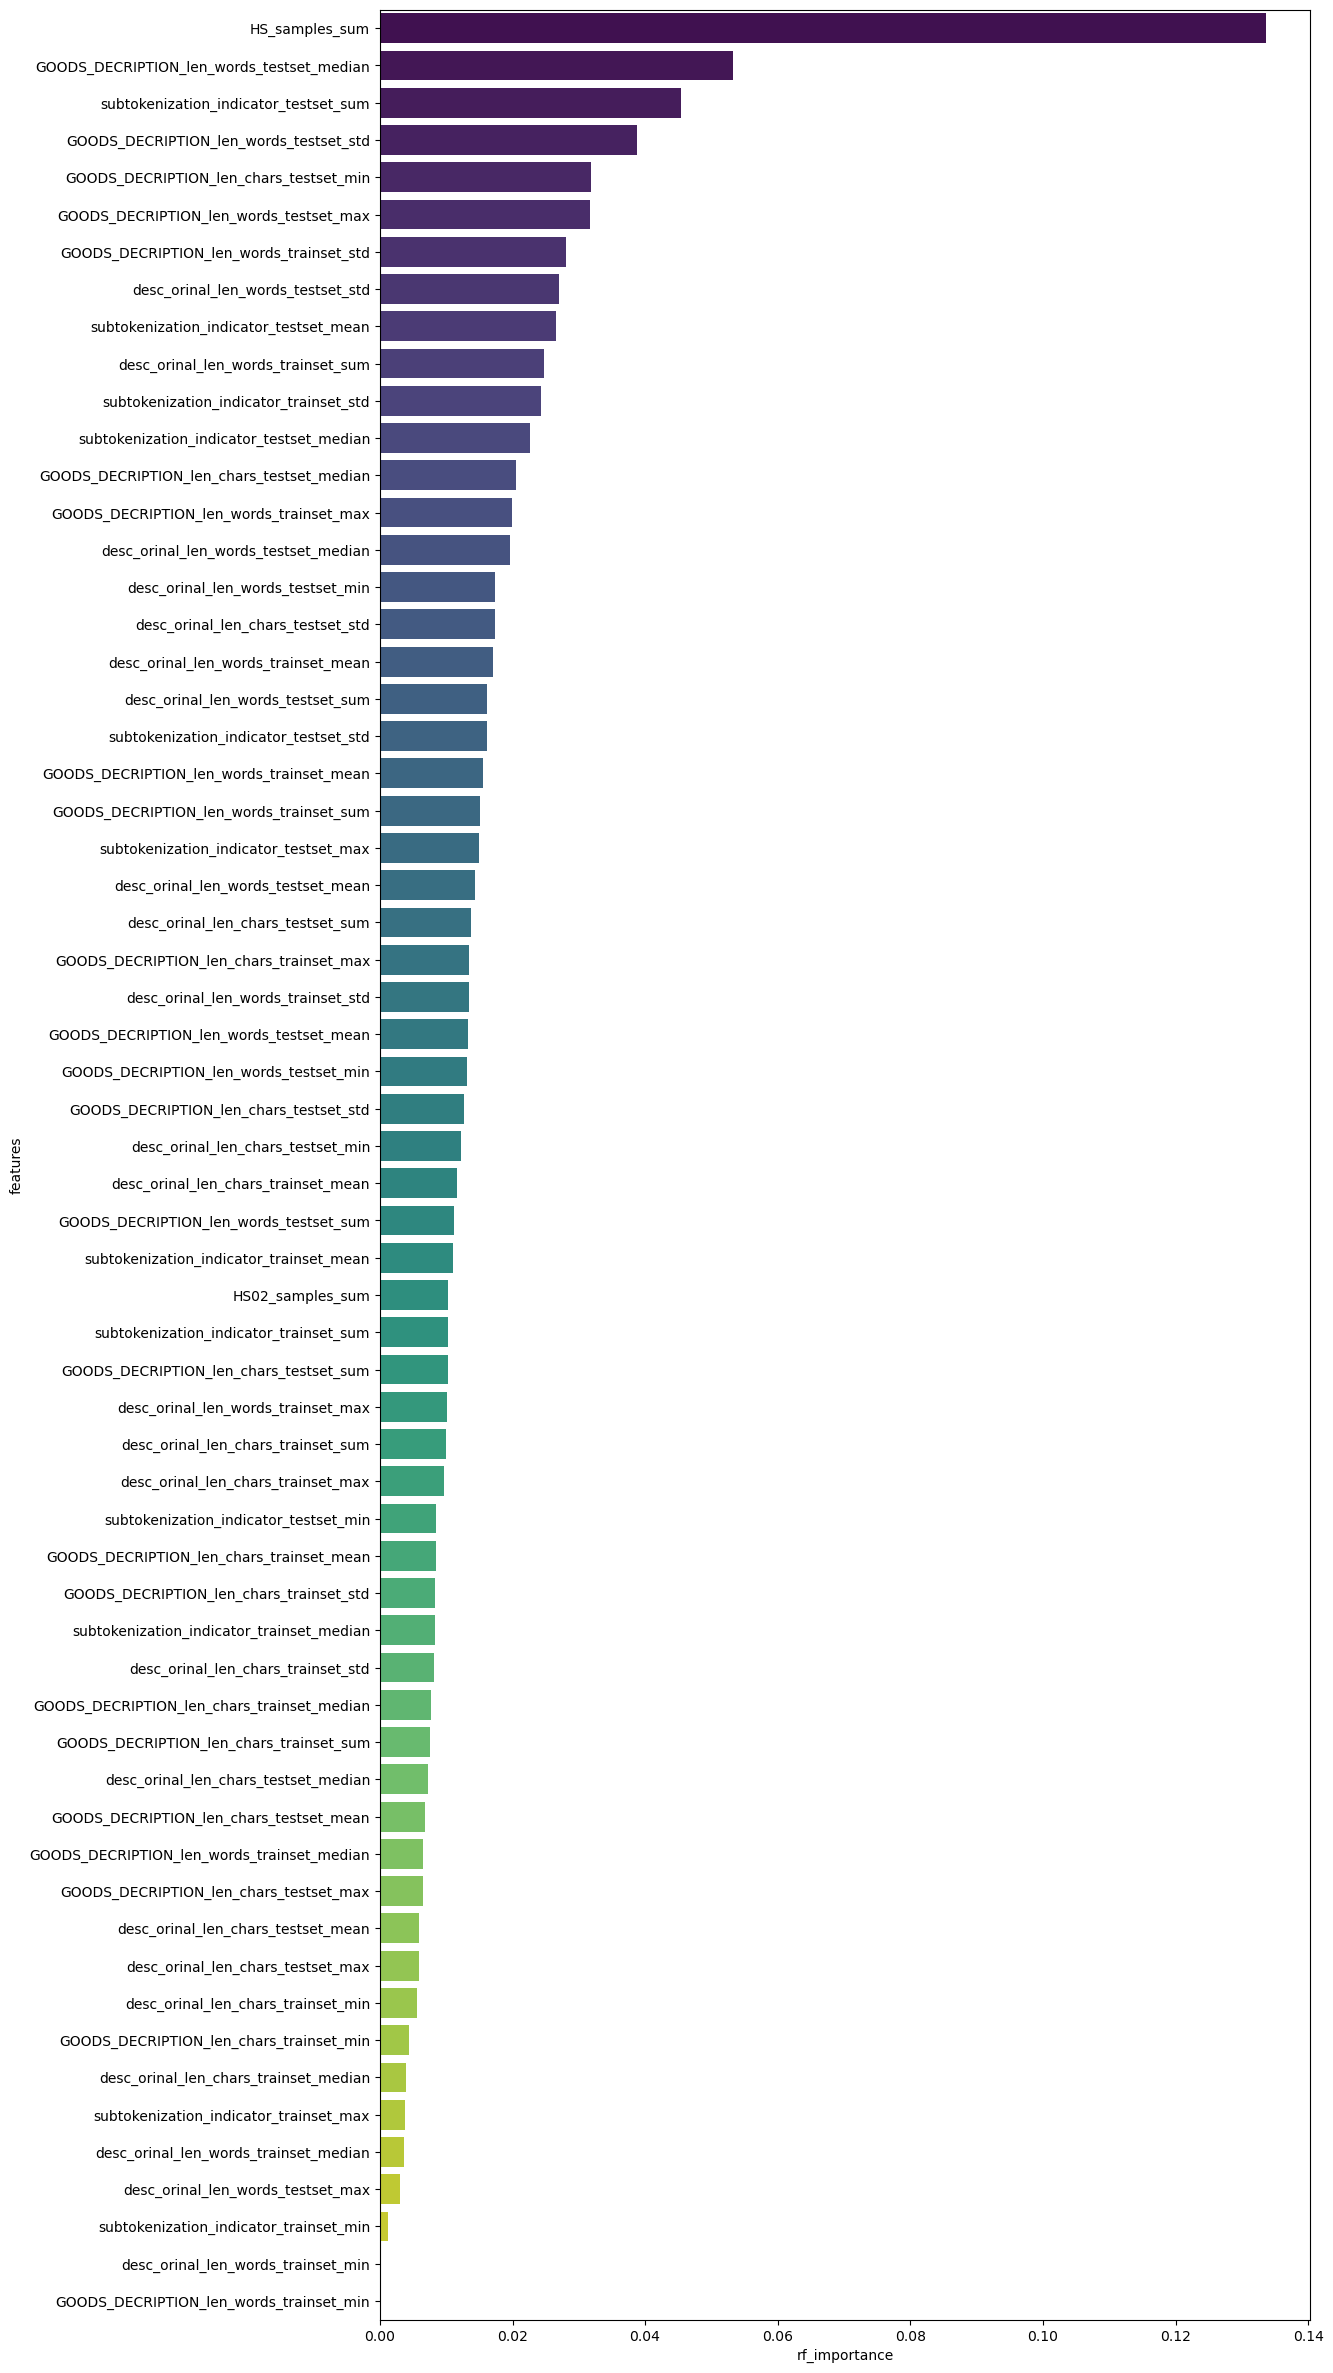

In [80]:
df_rf_feature_import = get_rf_importance(HS02_merged, 
                                         numeric_and_bool, 
                                         target='pred_score_mean', 
                                         all_target_info=target_info,
                                         plot=True)

Median features are more relevant than mean ones, and for sure they are correlated.

In [81]:
median_cols = [col for col in HS02_merged.columns if col.endswith('_mean')]

HS02_merged.drop(median_cols, axis=1, inplace=True)

In [82]:
for col in median_cols:
    numeric_and_bool.remove(col)

In [83]:
HS02_merged

,HS02_,HS_samples_sum,HS02_samples_sum,desc_orinal_len_words_trainset_sum,desc_orinal_len_words_trainset_min,desc_orinal_len_words_trainset_median,desc_orinal_len_words_trainset_max,desc_orinal_len_words_trainset_std,desc_orinal_len_chars_trainset_sum,desc_orinal_len_chars_trainset_min,...,top1_top2_proba_diff_sum,top1_top2_proba_diff_min,top1_top2_proba_diff_median,top1_top2_proba_diff_max,top1_top2_proba_diff_std,mean_top3_proba_sum,mean_top3_proba_min,mean_top3_proba_median,mean_top3_proba_max,mean_top3_proba_std
0,01,5707,14161,716,1,5.0,20,3.968057,4090,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02,35471,67081,1357,1,5.0,14,3.045621,8590,4,...,0.419368,0.419368,0.419368,0.419368,NaN,0.249229,0.249229,0.249229,0.249229,NaN
2,03,707,3481,174,1,2.0,9,1.633947,1078,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04,350304,1263376,6242,1,5.0,20,3.607378,39770,4,...,1.828283,0.006063,0.061399,0.824538,0.381055,1.267857,0.090513,0.131778,0.310332,0.094946
4,05,45,225,36,1,2.0,5,1.055597,205,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,93,728,3364,223,1,3.0,12,2.700239,1457,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,94,15309068,51236964,29964,1,3.0,32,2.777938,184789,3,...,12.801779,0.005896,0.275691,0.970061,0.304539,8.277247,0.030886,0.256975,0.331121,0.088667
93,95,5200271,14326225,15375,1,4.0,28,2.241286,90318,3,...,4.151820,0.011439,0.106932,0.927133,0.343200,2.362206,0.054081,0.133549,0.319331,0.098174
94,96,1094277,7634169,11051,1,3.0,22,2.428783,66698,3,...,1.744099,0.003119,0.044560,0.685375,0.184909,1.600238,0.033143,0.098303,0.261462,0.073432


C:\Users\santt\AppData\Local\Temp\ipykernel_12240\3671148677.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='rf_importance', y=df_rf_feature_import.index, data=df_rf_feature_import, palette='viridis')


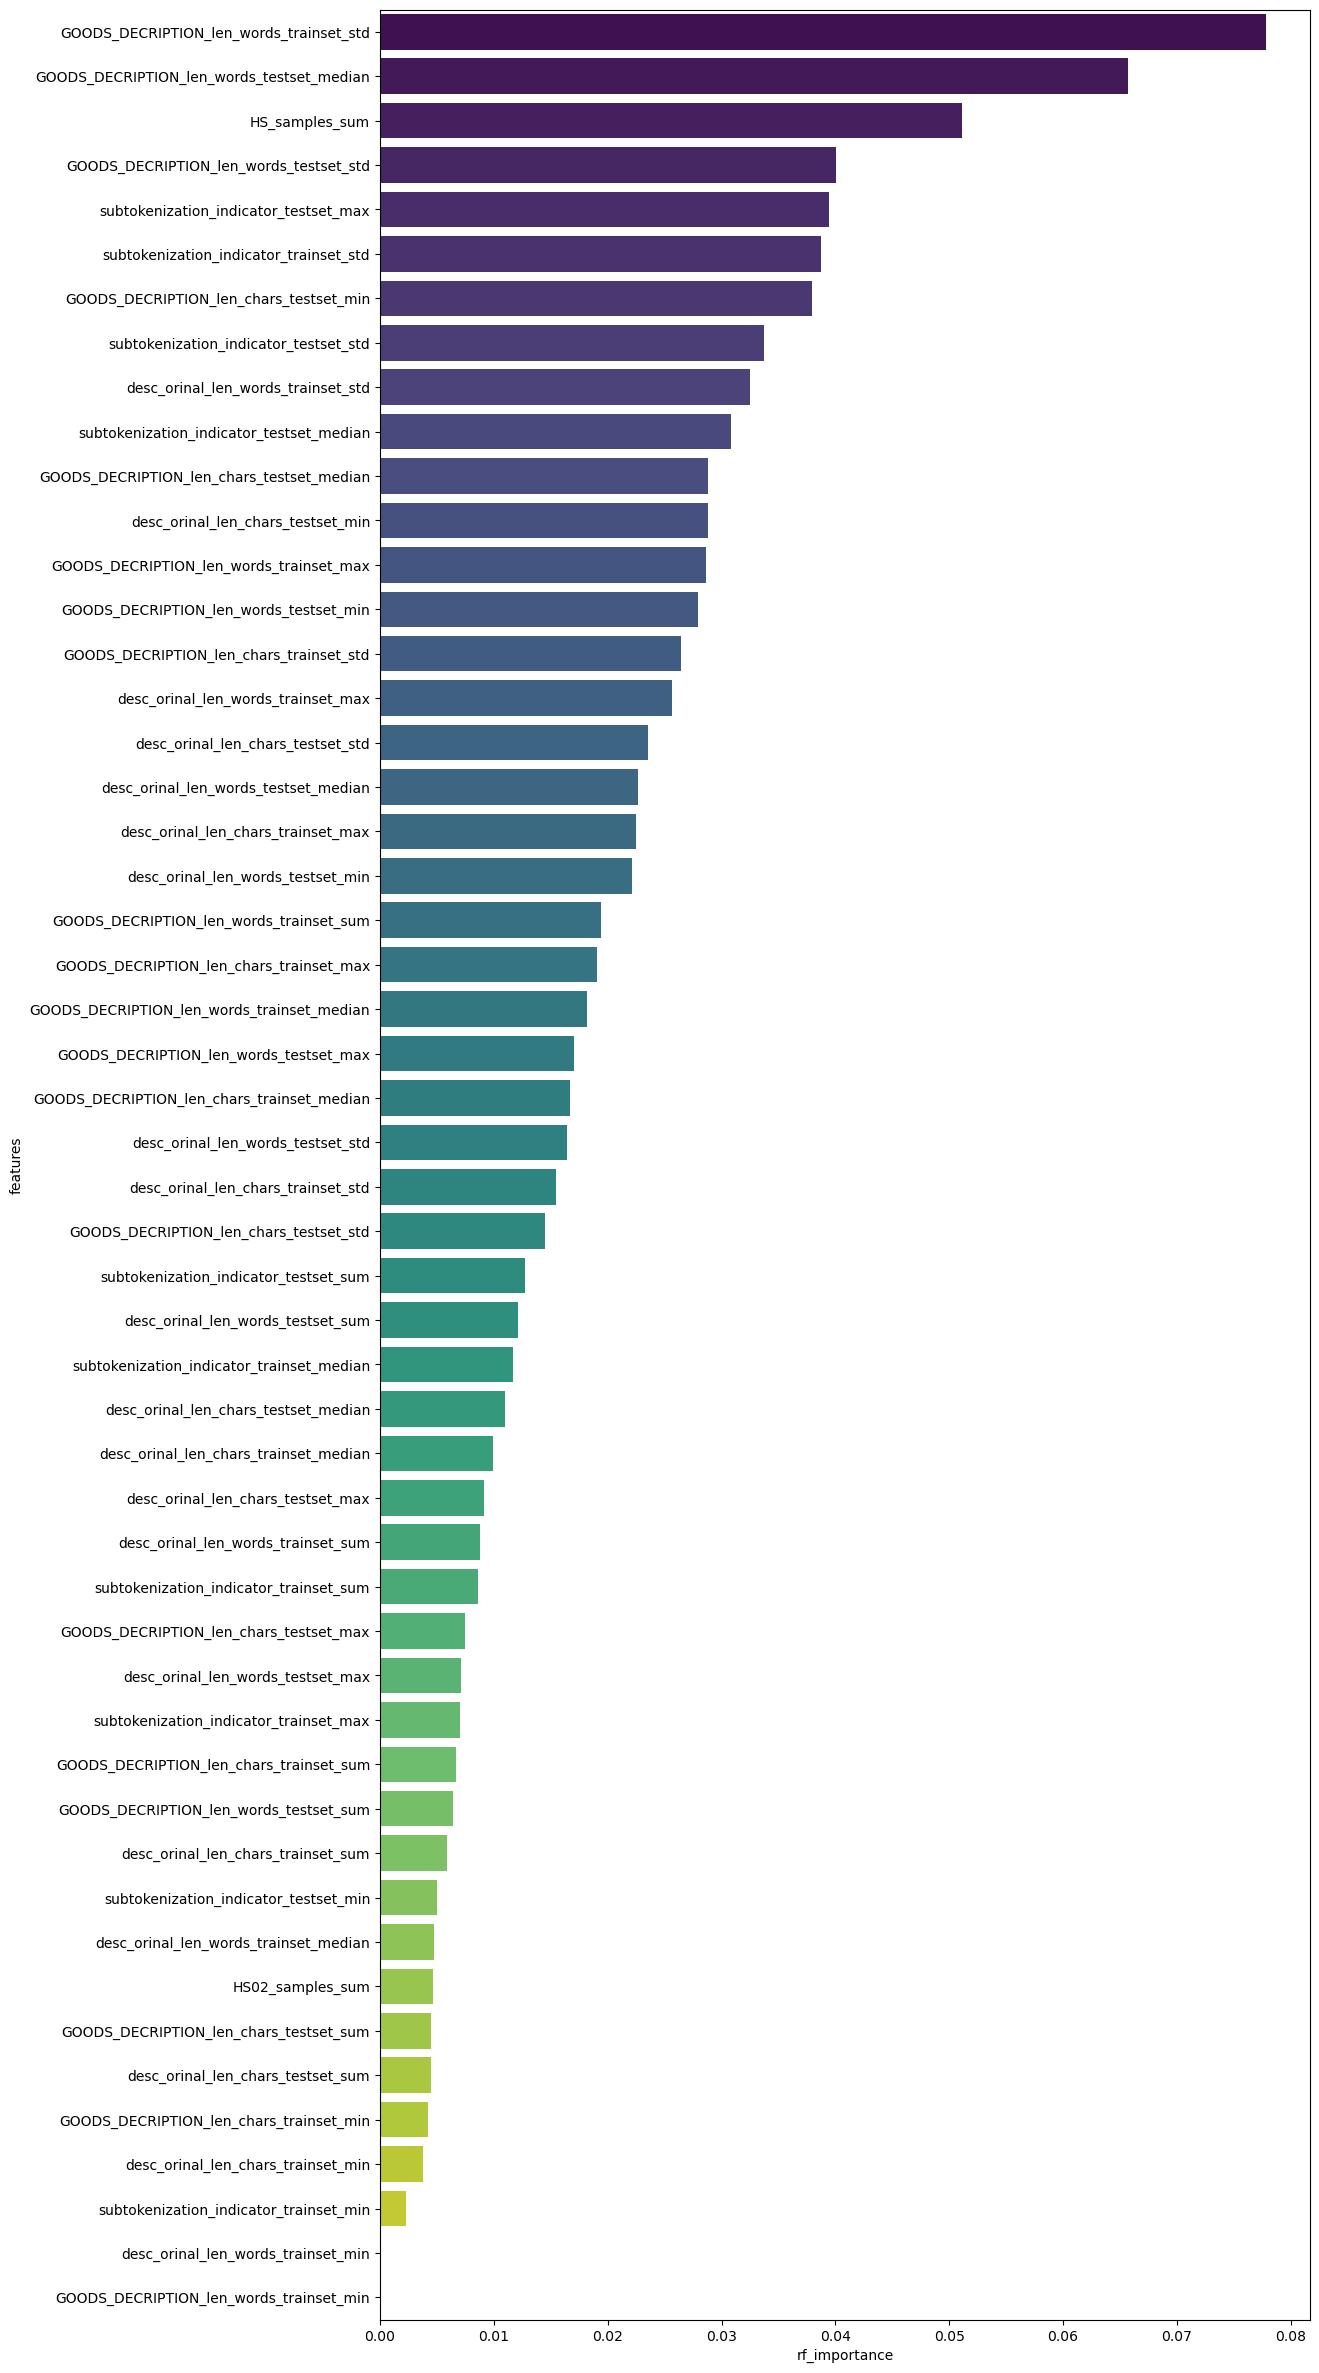

In [84]:
df_rf_feature_import = get_rf_importance(HS02_merged, 
                                         numeric_and_bool, 
                                         target='pred_score_median', 
                                         all_target_info=target_info,
                                         plot=True)

In [85]:
df_rf_feature_import.head(10).index

Index(['GOODS_DECRIPTION_len_words_trainset_std',
       'GOODS_DECRIPTION_len_words_testset_median', 'HS_samples_sum',
       'GOODS_DECRIPTION_len_words_testset_std',
       'subtokenization_indicator_testset_max',
       'subtokenization_indicator_trainset_std',
       'GOODS_DECRIPTION_len_chars_testset_min',
       'subtokenization_indicator_testset_std',
       'desc_orinal_len_words_trainset_std',
       'subtokenization_indicator_testset_median'],
      dtype='object', name='features')

<Axes: >

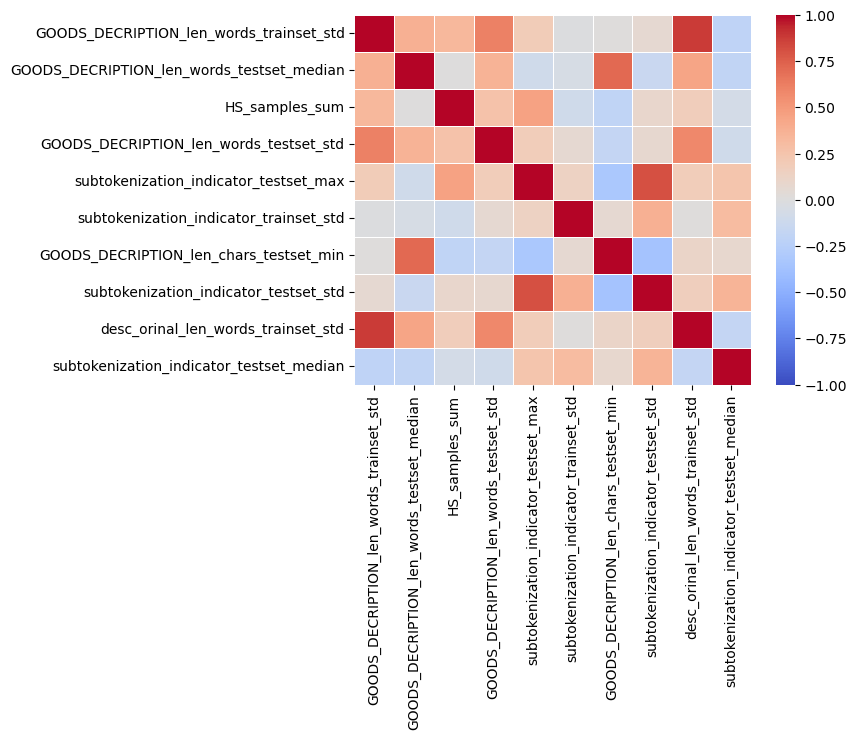

In [86]:
corr = HS02_merged[df_rf_feature_import.head(10).index].corr()

sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths =0.5, annot_kws={'size':10},vmin=-1)

In [91]:
var_ = ['subtokenization_indicator_trainset_std',
       'subtokenization_indicator_testset_median']

get_rf_importance(HS02_merged, 
                    var_, 
                    target='pred_score_median', 
                    all_target_info=target_info,
                    plot=False)

,rf_importance
features,
subtokenization_indicator_trainset_std,0.546786
subtokenization_indicator_testset_median,0.453214


In [88]:
var_ = ['GOODS_DECRIPTION_len_chars_trainset_max',
       'desc_orinal_len_chars_trainset_max']

get_rf_importance(HS02_merged, 
                    var_, 
                    target='pred_score_median', 
                    all_target_info=target_info,
                    plot=False)

,rf_importance
features,
GOODS_DECRIPTION_len_chars_trainset_max,0.561423
desc_orinal_len_chars_trainset_max,0.438577


___

Transfer learning model

In [89]:
results_transfer

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3
141824,ROLLER 18 BELT,8428,4010,0.687313,5910,0.044510,8482,0.036358
19947,BOX WITH 3 BAGS OF STERILIZING SOLUTION FORMAL...,2912,3822,0.076180,3923,0.065343,3808,0.062684
252599,Bar Chair Walnut Brown,9401,9401,0.408652,9403,0.337612,7009,0.024683
138515,GASKET DI = 57 DE = 107 S = 2.0 FOR STEAM DN 5...,8422,8412,0.070070,8413,0.065943,2804,0.050023
85866,CERAMIC LINERS FMC 435 & W 1122 1267586,6914,6902,0.050182,7606,0.044800,8414,0.027559
...,...,...,...,...,...,...,...,...
13086,ALPRO SOYA ORIG UHT 1 LTR,2202,2710,0.161922,2202,0.150514,3808,0.078953
48840,NBR 86 x 114 x 160,4002,4002,0.546914,4016,0.062231,6902,0.036882
157413,LAPTOP COMPUTER LENOVO NB WS P 15 G 2,8471,8471,0.991070,8517,0.003760,8473,0.003595
123267,CYLINDER BLOCK ASSY L SPARE PARTS FOR EXCAVATOR,8409,8409,0.186665,8431,0.155438,8484,0.112841


In [90]:
df_test_sample

,HS,GOODS_DECRIPTION,HS02,desc_orinal,HS_samples,HS02_samples,desc_orinal_len_words,desc_orinal_len_chars,GOODS_DECRIPTION_len_words,GOODS_DECRIPTION_len_chars,subtokenization_indicator
141824,8428,ROLLER 18 BELT,84,ROLLER 18 BELT,1,190,3,14,3,14,1.000000
138515,8422,GASKET DI = 57 DE = 107 S = 2.0 FOR STEAM DN 5...,84,GASKET DI=57 DE=107 S=2.0 FOR STEAM DN 50 PN16UNI,3,190,9,49,17,57,1.411765
138121,8422,2513931002 MUFFLER,84,2513931002 MUFFLER,3,190,2,18,2,18,4.000000
138983,8422,SLEEVE FOR PLASTIC TUBE,84,SLEEVE FOR PLASTIC TUBE,3,190,4,23,4,23,1.000000
154779,8467,Drills of all kinds,84,Drills of all kinds,6,190,4,19,4,19,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
210814,8607,DUPLEX CHECK VALVE E NPT,86,DUPLEX CHECK VALVE E'' NPT,2,2,5,26,5,24,1.400000
210767,8607,AIR EMERGENCY BRAKE VALVE,86,AIR EMERGENCY BRAKE VALVE,2,2,4,25,4,25,1.000000
335,0203,WHEATLAND MEADOW MEATS SPANISH CHORIZO 1670 G,02,WHEATLAND MEADOW MEATS SPANISH CHORIZO1670G,1,1,5,43,7,45,1.571429
15757,2309,FISH FARM SUPPLIES,23,FISH FARM SUPPLIES,2,2,3,18,3,18,1.000000
